# DC-EGM med Max's Model

## load packages and dependencies

In [4]:
#Dependencies
import jax
import numpy as np
import jax.numpy as jnp
from dcegm.pre_processing.setup_model import setup_model

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm
import os

import sys
sys.path.insert(0, "/Users/frederiklarsen/Thesis/Thesis")
sys.path.insert(1, "/Users/frederiklarsen/dcegm/")

# Verify if the paths are correctly added
import os

from model_functions_initial.utility import utility_functions
from model_functions_initial.final_period_utility import final_period_utility
from model_functions_initial.budget import budget_dcegm
from model_functions_initial.state_space_functions import create_state_space_function_dict
from model_functions_initial.compute_moments import compute_simulation_moments
from model_functions_initial.compute_moments import compute_simulation_moments_with_ci
from model_functions_initial.plots import plot_empirical_vs_simulated_with_ci
from model_functions_initial.estimation import estimate_msm

from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = "/Users/frederiklarsen/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash ee6660e #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

MLE estimates: alpha1 = 0.000417, alpha2 = 0.099277


## Load Data 

In [5]:
# Read CSV
df_edu = pd.read_csv(FILE_UDD3)
# read mortality and discard seoncd and third column
df_mort = pd.read_excel(Mortality, sheet_name="DOD", usecols=[0, 3])

# 2) standardize colomn name and remove _FREQ_ column
for df in (df_edu, df_edu, df_edu):
    # Rename ALDER → age
    if "ALDER" in df.columns:
        df.rename(columns={"ALDER": "age"}, inplace=True)
    # Remove _FREQ_-column if it exists
    if "_FREQ_" in df.columns:
        df.drop(columns=["_FREQ_"], inplace=True)



# 4) (Valgfrit) Kontrolprint 
#df_edu

## Options for model - Choices and states

In [6]:
n_periods = 55
choices = np.arange(5) # 5 choices

options = {
    "model_params": {
        #"quadrature_points_stochastic": 5, 
        "n_quad_points_stochastic": 25,
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "hours": jnp.array([0,250,750,1200,1700]), #list 
        "max_hours": 1500,
        "start_age": 30,
        "inc_threshold": 6.0,
        "tax_base_rate": 0.37,
        "tax_top_rate": 0.5,
        "retirement_age": 67,
        "oap_base_amount":0.80328,
        "oap_max_supplement": 0.92940,
        "supp_threshold": 0.79300,
        "oap_threshold": 3.3592,
        "supp_reduction_rate": 0.309,
        "oap_reduction_rate": 0.3,
        "alpha1": 0.000417, # independently estimated parameter for survival probability
        "alpha2": 0.1,  # independently estimated parameter for survival probability
        "max_init_experience": 5,
        "max_ret_period": 45, # Age 75
        "min_ret_period": 30, # Age 60
    },
    "state_space": {
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "continuous_states": {
            "wealth": np.linspace(0, 50, 20),
            "experience": jnp.linspace(0, 1, 5).astype(float) # 1 experince grid point, if experience can only go up by a year - more points if it is a fraction based on hours worked
        },
        "exogenous_processes": {
            "survival": {
                "transition": prob_survival,
                "states": [0, 1],
            },
        },
    },
}

# ====================================================================================================================

# Structural Estimation

## Initiatal parameters - some are estimated above, the rest to be structuraly estimated

In [7]:
beta0, beta1, beta2 = np.loadtxt("/Users/frederiklarsen/dcegm/Speciale/first_step/wage_params_udd3.txt")

params_initial = {}
params_initial["interest_rate"] = 0.01
params_initial["sigma"] = 0.11436398 # income shock scale
params_initial["lambda"] = 0.96854512 # taste shock scale

# discount factor
params_initial["beta"] = 0.99633022

# parameters for the utility function
params_initial["rho"]=0.77007267

# disutility of each hours choice
params_initial["gamma"]=jnp.array([0.7949593,1.65520093,2.12902941,1.73385035]) 

# Age component disutility
params_initial["kappa1"]=0.06931974
params_initial["kappa2"]=0.00377771

# transsition cost
params_initial["phi"]=0.99926288

# bequest parameters
params_initial["b_scale"]=1.53314057
params_initial["xi"]=0.18549496


# labor market parameters
params_initial["eta_edu1"]=1.81532136


# mortality parameters
params_initial["alpha1"]=0.000417
params_initial["alpha2"]=0.099277



# wage parameters
# ----- EDU LEVEL 3 -----
params_initial["beta0"]=beta0
params_initial["beta1"]=beta1
params_initial["beta2"]=beta2
params=params_initial.copy()

In [8]:
model = setup_model(
    options=options,
    state_space_functions=create_state_space_function_dict(),
    utility_functions=utility_functions,
    utility_functions_final_period=final_period_utility,
    budget_constraint=budget_dcegm,
)

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  50
Model setup complete.



In [15]:
# # validate model
# validate_exogenous_processes(model, params)

# ====================================================================================================================

## Initial values for simulating. 

In [9]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132



key = jax.random.PRNGKey(0)              # whatever seed you like
n = n_individuals                        # how many draws

# define your class‐labels and their probabilities
labels = jnp.array([0, 1, 2, 3], dtype=jnp.int32)
probs  = jnp.array([0.25, 0.20, 0.25, 0.509])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial = {
    "period": jnp.zeros(n_individuals),       # Every individual starts at period 0 (age 30)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.8).astype(float),  # Every individual starts with 5 years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial = jnp.full(n_individuals, 0.59)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments

## Simulate model

In [34]:
sim_func_aux = get_sol_and_sim_func_for_model(
    model=model,
    states_initial=states_initial,
    wealth_initial=wealth_initial,
    n_periods=options["state_space"]["n_periods"],
    seed=seed,
)


In [35]:
output_dict_aux = sim_func_aux(params)

## Convert simulation results to DataFrame

In [36]:
df_sim = create_simulation_df(output_dict_aux["sim_dict"])

#print to excel
#df_sim.to_excel("/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Resultater/simulation_output.xlsx")


#print all individuals
#df_sim


#print a select individual
df_sim.loc[(slice(None), 20),:] 

,,acc_exp,choice,consumption,experience,income_shock,labor_income,lagged_choice,lumpsum,net_labor,period_pension,...,taste_shocks_0,taste_shocks_1,taste_shocks_2,taste_shocks_3,taste_shocks_4,value_choice_0,value_choice_1,value_choice_2,value_choice_3,value_choice_4
period,agent,,,,,,,,,,,,,,,,,,,,,
0,20,NaN,4,0.590000,0.800000,0.381223,NaN,3,NaN,NaN,NaN,...,0.440336,-0.965859,-3.283728,-0.064554,3.002991,24.838095,21.695952,17.678174,25.656020,28.452963
1,20,5.855556,4,2.420073,0.855556,0.144675,6.244637,4,0.000000,3.122319,0.000000,...,-2.176979,1.275542,-0.847052,-2.023656,2.367915,24.462439,26.316173,22.428811,22.772197,33.417772
2,20,6.790476,4,2.638865,0.895238,-0.210357,5.115231,4,0.000000,3.222595,0.000000,...,-1.795030,1.562395,-0.686966,2.131443,-0.289852,25.421908,27.267902,23.233790,27.580784,31.425598
3,20,7.775000,4,2.646703,0.925000,-0.229037,3.717533,4,0.000000,2.342046,0.000000,...,-2.754991,0.641028,1.401730,-2.256967,1.831261,24.006654,25.925586,24.960216,22.860192,33.237121
4,20,8.792593,4,2.657764,0.948148,0.175696,3.777529,4,0.000000,2.379843,0.000000,...,-0.524654,1.166045,1.213636,-2.759788,0.026364,25.767084,26.016124,24.394999,22.016202,31.103101
5,20,9.833333,0,1.957545,0.966667,-0.072071,5.855110,4,0.000000,3.688719,0.000000,...,3.108305,-2.579046,-3.676232,-0.328450,-2.955967,30.057855,23.016280,20.210957,25.148362,28.798078
6,20,10.272727,0,1.660577,0.878788,0.576770,0.000000,0,0.000000,0.000000,0.000000,...,-1.255524,-0.966409,1.062117,0.364050,-0.406588,27.681178,23.356997,23.791539,24.728702,27.047479
7,20,10.638889,0,1.440353,0.805556,-0.089127,0.000000,0,0.000000,0.000000,0.000000,...,0.437092,-0.739658,1.491181,0.435886,0.168818,28.329101,22.550857,23.281581,23.907550,26.746097
8,20,10.948718,0,1.278819,0.743590,-0.344180,0.000000,0,0.000000,0.000000,0.000000,...,1.517590,0.714248,0.542554,-2.642128,-0.303488,28.520356,23.136582,21.544241,20.067023,25.506130


In [37]:
# hours_map = options["model_params"]["hours"]
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
# start_age = options["model_params"]["start_age"]
start_age = 30  # Or start_age = options["model_params"]["start_age"]


moments_sim = compute_simulation_moments(df_sim, start_age, hours_map)
moments_sim


,age,prob_work,hours_0,hours_1,hours_2,hours_3,hours_4,avg_wealth,work_work,nowork_nowork,...,avg_hours,var_wage,skew_wage,pens,net_labor,survival,avg_consumption,n_individuals,avg_experience,avg_labor_income
0,30,0.700900,0.299100,0.125300,0.059000,0.198600,0.318000,0.590000,0.641100,0.147800,...,1338.215152,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.573724,10000,0.000000,0.000000
1,31,0.696500,0.303500,0.084700,0.030900,0.109600,0.471300,1.649894,0.609400,0.212000,...,1553.912419,4.942527e-07,0.835190,0.000000,1.368013,1.0,1.396813,10000,5.761611,2.834235
2,32,0.726645,0.273355,0.068214,0.022104,0.078616,0.557712,2.131408,0.627626,0.204441,...,1645.209911,5.351081e-07,0.824199,0.000000,1.606440,1.0,1.680072,9998,6.491734,3.309472
3,33,0.764429,0.235571,0.061618,0.019706,0.061719,0.621386,2.513100,0.670001,0.178954,...,1688.909971,5.692943e-07,0.887056,0.000000,1.814619,1.0,1.896650,9997,7.226878,3.650496
4,34,0.794997,0.205003,0.059030,0.015508,0.059530,0.660930,2.838008,0.708154,0.148674,...,1710.124591,6.054497e-07,0.830342,0.000000,2.006329,1.0,2.077977,9995,7.983280,3.935541
5,35,0.819201,0.180799,0.054660,0.016318,0.051857,0.696366,3.110220,0.740014,0.125939,...,1729.017475,6.713181e-07,0.790958,0.000000,2.160803,1.0,2.232088,9989,8.762991,4.188555
6,36,0.834084,0.165916,0.051167,0.016321,0.051367,0.715230,3.346135,0.764394,0.111144,...,1739.327731,7.004286e-07,0.830377,0.000000,2.298803,1.0,2.360791,9987,9.567556,4.406285
7,37,0.844436,0.155564,0.043073,0.015226,0.052990,0.733146,3.556038,0.778023,0.099569,...,1757.449585,7.603580e-07,0.848334,0.000000,2.413497,1.0,2.478602,9983,10.391409,4.622526
8,38,0.853822,0.146178,0.048492,0.016231,0.053502,0.735598,3.744378,0.792706,0.094379,...,1746.831730,7.946909e-07,0.828678,0.000000,2.517999,1.0,2.571359,9981,11.234270,4.833942
9,39,0.867416,0.132584,0.045231,0.017551,0.053956,0.750677,3.899479,0.806038,0.084946,...,1753.370332,8.236368e-07,0.830021,0.000000,2.584876,1.0,2.652606,9971,12.085677,4.966143


# Estimation

In [31]:
#keep_cols = ["hours_0","hours_1","hours_2","hours_3", "hours_4","avg_wealth", "avg_hours"]
keep_cols = ["hours_4", "avg_hours", "avg_wealth"]
def crit_func_scipy(theta_array):
    """
    High-level objective function for MSM that updates all parameters,
    runs the simulation, computes simulated moments and compares them
    to empirical moments. The objective is the weighted sum of squared differences,
    where the weights are given by the inverse of the variances of the empirical moments.
    
    theta_array: a numpy array with 13 elements corresponding to:
       [rho, sigma, lambda, beta, rho, gamma1, gamma2, gamma3,
        beta0, beta1, beta2, kappa1, kappa2]
    """

    # fixed model params
    params["interest_rate"] = 0.01
    params["beta0"]= beta0
    params["beta1"]= beta1
    params["beta2"]= beta2
    # Update model parameters from theta_array
    params["sigma"] = theta_array[0]
    params["lambda"] = theta_array[1]
    params["beta"] = theta_array[2]
    params["rho"] = theta_array[3]
    params["gamma"] = jnp.array([theta_array[4], theta_array[5], theta_array[6], theta_array[7]])
    params["kappa1"] = theta_array[8]
    params["kappa2"] = theta_array[9]
    params["phi"] = theta_array[10]
    params["b_scale"] = theta_array[11]
    params["xi"] = theta_array[12]
    params["eta_edu1"] = theta_array[13]

    # Run the simulation
    output_dict_aux = sim_func_aux(params)
    df_sim = create_simulation_df(output_dict_aux["sim_dict"])

    # Compute simulated moments - returning a dataframe similar to the actual data
    sim_moments = compute_simulation_moments(df_sim, start_age, hours_map)
    empirical_moms = df_edu  # Your empirical moments DataFrame

    # Drop the "pens" column from both simulated and empirical moments if present
    if "pens" in sim_moments.columns:
        sim_moments = sim_moments.drop(columns=["pens"])
    if "pens" in empirical_moms.columns:
        empirical_moms = empirical_moms.drop(columns=["pens"])

    # Select only the columns of interest for the moments comparison
    sim_moments = sim_moments[keep_cols]
    empirical_moms = empirical_moms[keep_cols]
    # Convert DataFrames to numpy arrays.
    # They should have the same shape, e.g., (num_ages, num_moments)
    sim_vals = sim_moments.to_numpy()
    emp_vals = empirical_moms.to_numpy()

    # Debug-print shapes so that we can ensure they are the same shape
    #print("Simulated moments shape:", sim_vals.shape)
    #print("Empirical moments shape:", emp_vals.shape)

    # Compute the difference between simulated and empirical moments.
    # diff will have shape (num_ages, num_moments)
    diff = sim_vals - emp_vals

    # Now, for each moment (each column), compute the sample variance of the empirical moment
    ## Should be computed through the data before moments i think
    emp_var = np.nanvar(emp_vals, axis=0, ddof=1)  # Sample variance
    # compute simulated moments variance
    sim_var = np.nanvar(sim_vals, axis=0, ddof=1)  # Sample variance

    total_var = emp_var + sim_var

    # Set a small epsilon to avoid division by zero.
    epsilon = 1e-6

    # The weight for each moment is defined as 1/(variance + epsilon).
    weights = 1.0 / (emp_var + epsilon)
  
    # Instead of forming a full weighting matrix, we can compute the objective by summing over moment columns.
    # For each moment i, compute the sum of squared differences over ages, multiplied by its weight.
    # as in crit = diff^T * W * diff
    # where W is a diagonal matrix with weights on the diagonal.
    # The crit_val is the sum of the weighted squared differences.
    
    num_moments = diff.shape[1]
    crit_val = 0.0
    for i in range(num_moments):
        crit_val += weights[i] * np.nansum(diff[:, i] ** 2)
    
    print("Crit value:", crit_val)
    return float(crit_val)

# Example initial guess with 12 parameters:params = {}

initial_guess = np.array([
    0.29517459,     # sigma
    1.62160391,     # lambda
    0.98511955,     # beta
    0.18525417,      # rho
    0.41764602, 1.66070244, 2.33390033, 1.32264638,  # gamma[0..3]
    0.0, 0.00428177, 2.92025071, 0.55830872,  # kappa1, kappa2, phi, b_scale
    0.016428,     # xi
    0.51036246      # eta_edu1
], dtype=float)
result = minimize(crit_func_scipy, initial_guess, method="Nelder-Mead", options={'disp': True})
print("Optimization result:")
print(result)


Crit value: 17.747630088008396
Crit value: 16.865424453533752
Crit value: 20.14941438891922
Crit value: 11934.65009300256
Crit value: 16.656481154867848
Crit value: 17.066067285314105
Crit value: 17.611511710273653
Crit value: 17.612318449893614
Crit value: 23.138157806764042
Crit value: 17.905993617968264
Crit value: 18.90644746092965
Crit value: 17.119872667280188
Crit value: 15.669979012677098
Crit value: 18.231561493819925
Crit value: 17.725933770043014
Crit value: 164.46603368960947
Crit value: 157.92057827979335
Crit value: 9445.141838934418
Crit value: 139.68331042249818
Crit value: 4304.998713639072
Crit value: 106.00441487969766
Crit value: 831.9688888273149
Crit value: 67.0017800120794
Crit value: 132.92144707827342
Crit value: 39.81018159818718
Crit value: 30.52467903011085
Crit value: 16.819063653814098
Crit value: 12.729116099744921
Crit value: 10.016357800118485
Crit value: 15.43684025709185
Crit value: 13.490116068973162
Crit value: 13.820822665032775
Crit value: 13.6439

In [32]:
parameters = result.x
parameters


array([ 2.67139492e-01,  1.76205400e+00,  9.84827262e-01,  1.91455305e-01,
        4.31304226e-01,  2.57606743e+00,  2.10649055e+00,  1.33623309e+00,
       -1.51741712e-04,  2.73500773e-03,  3.25734992e+00,  6.78163382e-01,
        1.47695474e-02,  3.95419158e-01])

In [33]:
# # Update the parameters in the params dictionary
params["sigma"] = parameters[0]     # 9.65073027e-02
params["lambda"] = parameters[1]    # 1.07262365e+00
params["beta"] = parameters[2]      # 9.11752988e-01
params["rho"] = parameters[3]       # 1.17380827e+00
params["gamma"] = jnp.array([parameters[4], parameters[5], parameters[6], parameters[7]]) # 2.28588031e+00, 3.13596501e+00, 3.24554860e+00, 1.62224838e+00
params["kappa1"] = parameters[8]    # -2.88010333e-02
params["kappa2"] = parameters[9]    # 1.69999238e-03
params["phi"] = parameters[10]      # 9.79359668e-03
params["b_scale"] = parameters[11]  # 2.36947625e+00
params["xi"] = parameters[12]       # 2.26797551e+00 
params["eta_edu1"] = parameters[13] # 4.58206470e-03

## Plots

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/prob_work_over_age_edu3.png


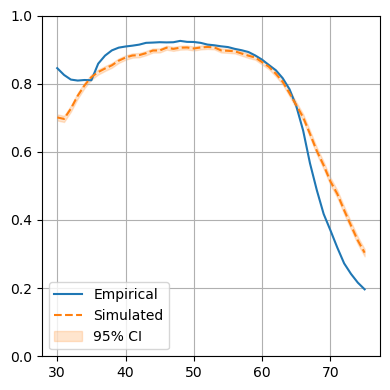

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/hours_0_over_age_edu3.png


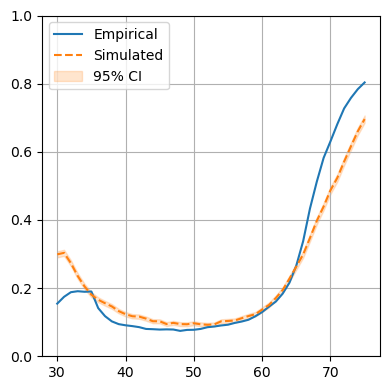

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/hours_1_over_age_edu3.png


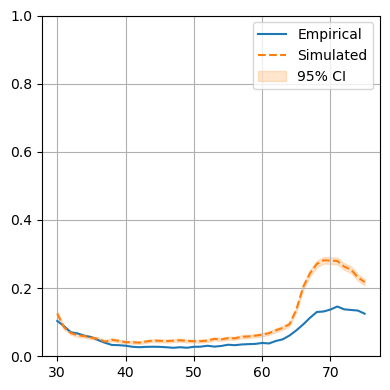

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/hours_2_over_age_edu3.png


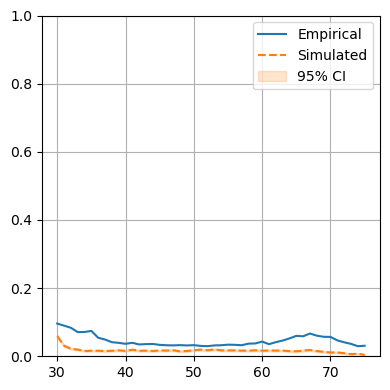

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/hours_3_over_age_edu3.png


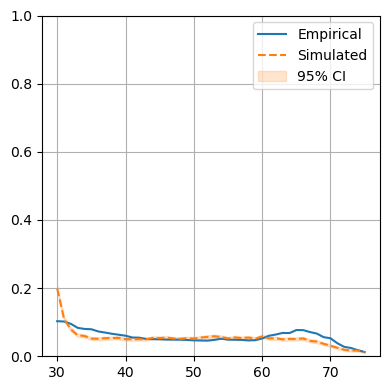

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/hours_4_over_age_edu3.png


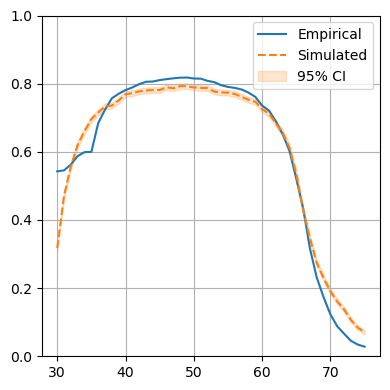

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/avg_wealth_over_age_edu3.png


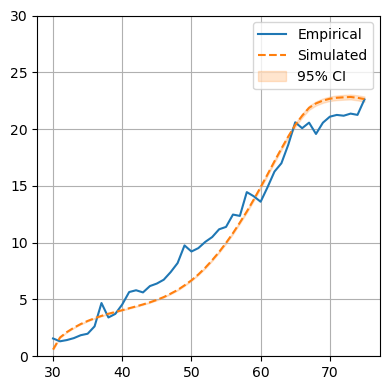

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/work_work_over_age_edu3.png


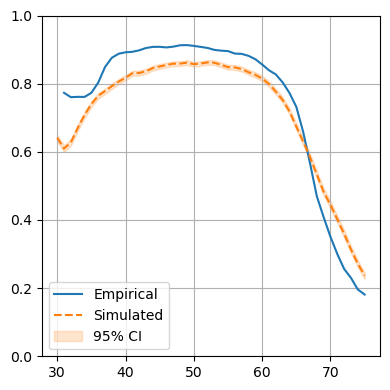

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/nowork_nowork_over_age_edu3.png


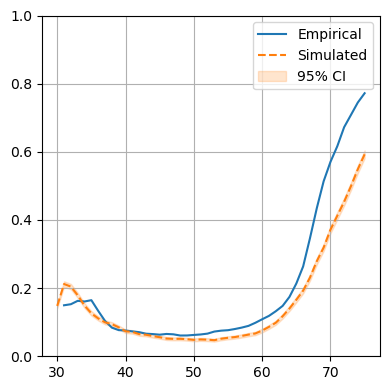

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/avg_experience_over_age_edu3.png


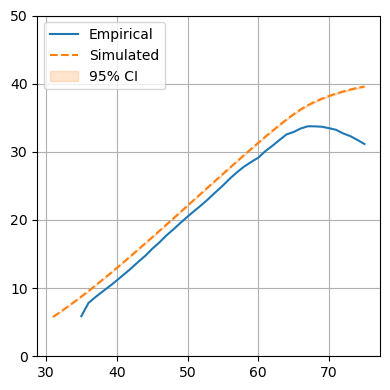

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/avg_labor_income_over_age_edu3.png


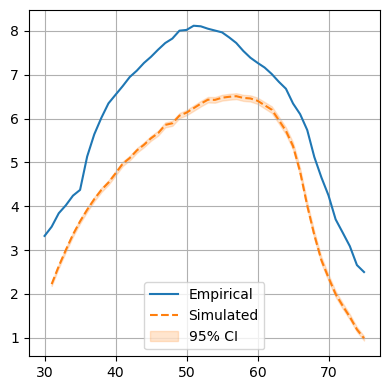

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/avg_wage_over_age_edu3.png


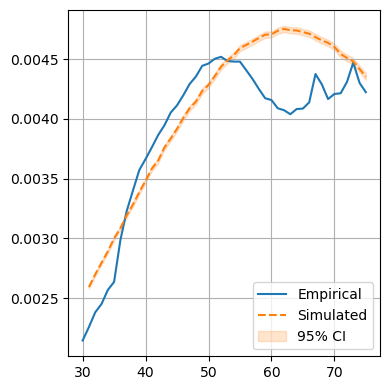

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/avg_hours_over_age_edu3.png


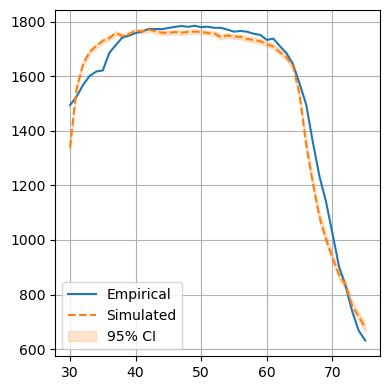

In [38]:
edu = df_edu.copy().loc[df_edu.age <= 75]       # empirical
moments_sim = compute_simulation_moments_with_ci(df_sim, start_age, hours_map)  # Call the function
moments_sim = moments_sim.loc[moments_sim.age <= 75]  # Filter simulated + CIs

# location to store plots in
BASE = "/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer"
# print plots
plot_empirical_vs_simulated_with_ci(edu, moments_sim, BASE, out_subfolder="edu3")